## Part 2

The Multi-Layer Perceptron with k layers and input $x\in\mathbb{R}^{n_1}$ takes the form
$$
f(x) = W_k \sigma(W_{k-1}\sigma(\dots(W_1x)))
$$
where $\sigma$ is some non-linear activation function and each $W_i$ is a real matrix in $\mathbb{R}^{n_{i+1}\times n_{i}}$ s.t. $f(x)\in\mathbb{R}^{n_{k+1}}$

In [1]:
def importData():
    from sklearn import datasets
    dataset = datasets.fetch_california_housing(as_frame = True)

    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    import numpy as np
    np.random.seed(1)

    dataset.frame_normalized = StandardScaler().fit_transform(dataset.frame)
    X = dataset.frame_normalized[:,0:len(dataset.frame.columns) - 1]
    y = dataset.frame_normalized[:,len(dataset.frame.columns) - 1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)
    X_train = np.insert(X_train, 0, np.ones(X_train.shape[0]), axis=1)
    X_test = np.insert(X_test, 0, np.ones(X_test.shape[0]), axis=1)

    return X_train, y_train, X_test, y_test

In [42]:
import numpy as np

def dot(W, x):
    '''
    Implementation of autodifferentiation of dot-product.
    Inputs:
        W: nxm real matrix
        x: an m-dimensional vector
    Output:
        val: evaluated value
        vjp: vector jacobian product for each of the inputs
    '''
    value = np.dot(W, x)

    def vjp(u):
        vjp_wrt_W = np.outer(u, x) 
        vjp_wrt_x = W.T.dot(u)
        return vjp_wrt_x, vjp_wrt_W
        
    return value, vjp

def relu(x):
    '''
    Implementation of autodifferentiation of relu activation function.
    Inputs:
        x: an m-dimensional vector
    Output:
        val: evaluated value
        vjp: vector jacobian product for x
    '''
    value = np.maximum(0, x)

    def vjp(u):
        gdash = (x>0).reshape(-1,1)
        vjp_wrt_x = u*gdash
        return vjp_wrt_x,  
    
    return value, vjp

def initialiseMLP_random(inputfeatures, layers, outputfeature):
    '''
    Function facilitating the setup of a MLP. 
    Inputs:
        inputfeatures: dimension of input
        layers: number of layers
        outputfeatures: dimension of output
    Outputs:
        W: list of with len(layers) matrices of desired dimension    
    '''
    dims = np.random.choice([i for i in range(2,8)], layers)
    W = [np.array(np.random.rand(dims[0], inputfeatures))]
    for i in range(1, len(dims)):
        Wi = np.array(np.random.rand(dims[i], dims[i-1]))
        W = np.insert(Wi, W, 0)
    W = np.insert(W, np.array(np.random.rand(outputfeature, dims[-1])))
    return W

def mlp2(x, W):
    """
    input: 
        x = input data
        W = list of weight matrices, W = [W2, W1]
    formula:
        y = W2.q(W1.x)
    returns:
        value = evaluated value according to formula
        vjp = tuple of vjp's in order x, W
    """
    W2, W1 = W
    a, vjp_dot1 = dot(W1, x)
    b, vjp_relu = relu(a)
    value, vjp_dot2 = dot(W2, b)

    def vjp(u):
        vjp_wrt_b, vjp_wrt_W2 = vjp_dot2(u)
        vjp_wrt_a, = vjp_relu(vjp_wrt_b)
        vjp_wrt_x, vjp_wrt_W1 = vjp_dot1(vjp_wrt_a) 

        return vjp_wrt_x, [vjp_wrt_W2, vjp_wrt_W1]
    return value, vjp

def mlpk(x, W): #W = [Wk, ..., W3, W2, W1]
    """
    input: 
        x = input data
        W = list of weight matrices, W = [Wk, ..., W3, W2, W1]
    formula:
        y = Wk(...q.W2.q(W1.x) )
    returns:
        value = evaluated value
        vjp = tuple of vjp's in order x, W
    """

    if (len(W)>=3):
        value, vjp_1 = mlpk(x, W[1:len(W)])
    else:
        return mlp2(x, [W[-2], W[-1]])
    
    value, vjp_2 = relu(value)
    value, vjp_3 = dot(W[0], value)

    def vjp(u):
        vjp_wrt_x, vjp_wrt_Wk = vjp_3(u)
        vjp_wrt_x, = vjp_2(vjp_wrt_x)
        vjp_wrt_x, *vjp_wrt_W = vjp_1(vjp_wrt_x)
        vjp_wrt_W = vjp_wrt_W[0]
        vjp_wrt_W.insert(0, vjp_wrt_Wk)
        return vjp_wrt_x, vjp_wrt_W

    return value, vjp

def squared_loss(y_pred, y, d):
    """
    Autodifferentiation of f = 1/(2n)||y_pred - y||**2 with gradient (1/n)*(y_pred-y)*[1, -1].T
    input: 
        y_pred, y
    returns:
        value = evaluated value
        vjp = tuple of vjp's in order y_pred, y
    """
    residual = y_pred - y
    def vjp(u):
        vjp_y_pred = u*(1*residual)/d
        vjp_y = u*(-1*residual)/d
        return vjp_y_pred, vjp_y
    value = 0.5 * np.sum(residual ** 2) / d
    return value, vjp

def loss_i(i, X, y, W):
    '''
    Implementation of autodifferentiation for SGD loss at ith component
    Inputs:
        i: index
        X: the feature matrix
        y: labels
        W: set of weights as a list
    Output:
        val: evaluated value
        vjp: vector jacobian product for x
    '''
    n, d = X.shape
    x = X[i]
    pred_value, predicted_vjp = mlpk(x, W)
    loss_value, loss_vjp = squared_loss(pred_value, y[i], d)
    value = loss_value

    def vjp(u):
        vjp_y, vjp_y_pred = loss_vjp(u)
        vjp_x, vjp_W = predicted_vjp(vjp_y)
        return vjp_x, vjp_y_pred, vjp_W
    
    return value, vjp

In [28]:
def SGD(niter, step, W, X_train, y_train):
    '''
    Implementation of SGD for mlp's
    Inputs:
        niter: number of iterations to run
        step: learning rate 
        W: list of weight matrices
        X_train: feature matrix
        y_train: vector of labels
    Output:
        loss_evol: loss at each iteration
        W: new set of weight matrices
    '''
    n, d = X_train.shape
    loss_evol = []

    for it in range(niter):
        if (it%n == 0):
            print(f'Epoch {it//n}', end='\r')
        index = np.random.choice(n, 1)[-1]

        vali, vjpi = loss_i(index, X_train, y_train, W, d)
        u = np.array([1]).reshape(-1,1)
        vjp_wrtx, vjp_wrty, vjp_wrtW = vjpi(u)

        for k in range(len(W)):
            W[k] = W[k] - (1/n)*vjp_wrtW[k]*step
    
        loss_evol.append(vali/n)

    return loss_evol, W


In [36]:
def findiff_mlp():
    print("Finite Differences for MLP")

    def f_rec(x,W):
        if len(W)==1:
            temp = np.dot(W, x).reshape(-1)
            return temp
        temp = np.dot(W[0], np.maximum(f_rec(x, W[1:]), 0))
        return temp

    x = X_train[int(np.random.choice(n, 1))]
    val, vjp = mlpk(x, W)
    assert(np.allclose(val, f_rec(x, W), rtol=1e-8)), 'values not equal'
    print("Pass: Equal Values")

    g = lambda x, eps, e: ( (f_rec(x+eps*e, W) - f_rec(x, W)) / eps )
    eps = 1e-4
    e = np.eye(1, d, 0).reshape(-1)

    findiff = np.zeros(len(x))
    for i in range(len(x)):
        findiff[i] = g(x, eps, np.eye(1,d, i).reshape(-1))

    #VJP with ei extracts ith row
    u = np.array([1]).reshape(-1,1)
    calculated_vjpX, calculated_vjpW = vjp(u)
    assert(np.allclose(findiff, calculated_vjpX.reshape(-1), rtol=1e-6)), "vjp's not equal"
    print("Pass: Equal VJP's")

findiff_mlp()

Finite Differences for MLP
Pass: Equal Values
Pass: Equal VJP's


In [43]:
def findiff_sq():
    print("Finite differences squared loss")
    def f_sq(x1, x2, d):
        res = (x1-x2)
        res = res**2
        res = np.sum(res)
        res = res/(2*d)
        return res
    eps = 1e-8

    np.random.seed(2)
    x1 = np.random.uniform(0,1,d)
    x2 = np.random.uniform(0,1,d)

    val, vjp = squared_loss(x1, x2, d)

    vjpx1, vjpx2 = vjp(1)

    fd1 = np.zeros(len(x1))
    fd2 = np.zeros(len(x1))
    for i in range(len(x1)):
        ei = np.eye(1,d,i)
        fd1[i] = (f_sq(x1+eps*ei, x2, d) - f_sq(x1,x2, d))/eps
        fd2[i] = (f_sq(x1, x2+eps*ei, d) - f_sq(x1,x2, d))/eps

    assert(np.allclose(val, f_sq(x1, x2, d)))
    print("Pass: Equal values")
    assert(np.allclose(fd1, vjpx1))
    assert(np.allclose(fd2, vjpx2))
    print("Pass: Equal VJPs")
findiff_sq()

Finite differences squared loss
Pass: Equal values
Pass: Equal VJPs


We now turn to the dataset from Part 1, implement a very small MLP with 2 layers and train it using SGD.

In [44]:
X_train, y_train, X_test, y_test = importData()
n, d = X_train.shape

innerdim = 5
W0 = np.random.randn(innerdim, d)        #np.ones((innerdim, d)) #   
W1 = np.ones((innerdim, innerdim)) #np.random.randn(innerdim, innerdim)    
W2 = np.random.randn(1, innerdim)           #np.ones((1, innerdim)) 
W = [W2, W1, W0]
# print([i.shape for i in W])

[(1, 5), (5, 5), (5, 9)]


We run the model for 10 epochs.

In [ ]:
epochs = 10
errs, Wopt = SGD(niter=n*epochs, step=1e-5, W=W, X_train=X_train, y_train=y_train)

Unfortunately, the model does not seem to be learning; there must be some error but I have not been able to find it.

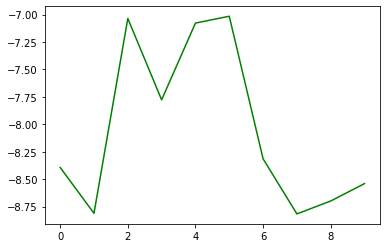

In [39]:
import matplotlib.pyplot as plt
t = np.linspace(0, epochs-1, epochs)
plt.plot(np.log(errs[::n]), 'g');

Indeed, using minibatching, we also obtain wildly oscillating results

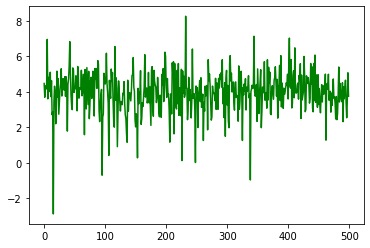

In [ ]:
def SGD_minibatch(niter, step, W, X_train, y_train, batchsize):
    n, d = X_train.shape
    loss_evol = []

    for it in range(niter):
        index = np.random.choice(n, batchsize)
        loss = 0
        grad = []
        u = np.array([1]).reshape(-1,1)

        for b in range(batchsize):
            vali, vjpi = loss_i(index[b], X_train, y_train, W)
            vjp_wrtx, vjp_wrty, vjp_wrtW = vjpi(u)

            loss += vali
            grad.append(vjp_wrtW)
        
        loss = loss / batchsize

        for l in range(len(W)):
            for j in range(1,len(grad)):
                #First element of grad has place for each W. Add all
                grad[0][l] += grad[j][l]
        grad = grad[0]
        #And then sum to average
        grad = [g/batchsize for g in grad]

        #Update
        for k in range(len(W)):
            W[k] = W[k] - grad[k]*step
    
        # Append value
        loss_evol.append(vali)
    return loss_evol

errs = SGD_minibatch(niter=500, step=1e-100, W=W, X_train=X_train, y_train=y_train, batchsize=3)
plt.plot(np.log(errs), 'g');